# Data Analysis - Liv

Welcome! So you want to find out more about your Spotify listening habits. Look no further! This notebook has monthly breakdowns, time of day breakdowns, as well as your top artists and songs!

The first section here is the code needed to generate the results. Feel free to skip ahead to your results, or try to figure out what the code is doing if you're interested :)

To the coders out there; I don't maintain that this code is particularly efficient or pythonic, and there are probably better ways to write it. However I wanted to make each function a standalone one that doesn't need the results from other functions. This does give rise to some duplicate code.

## The Code

In [1]:
# Import necessary libraries
import pandas as pd
import os
from collections import Counter
import matplotlib.pyplot as plt
import operator
import time
import datetime

In [36]:
# Change directory to the relevant dataset (ie 'NameData')
os.chdir('/Users/Yuval/Desktop/Yuval/SpotifyData/LivData/')
files = sorted(os.listdir())

In [37]:
def initial_df_processing():
    
    # Create a dataframe which has all the streaming history of the last year
    df = pd.DataFrame()
    for file in files:
        if 'Streaming' in file:
            df2 = pd.read_json(file)
            df = df.append(df2,ignore_index=True)
    
    # Time is currently in GMT- change it to AWST
    hours_added = datetime.timedelta(hours = 8)
    newtimes = []

    for index, row, in df.iterrows():

        londontime = row['endTime']
        t = datetime.datetime.strptime(londontime,"%Y-%m-%d %H:%M")
        new = t + hours_added
        new = str(new)
        newtimes.append(new)
    
    # Now update the times
    df['endTime'] = newtimes

    # Restricts the data to look only at the current year (2021)
    times = list(df['endTime'])
    oldyear = []
    newyear = []
    old = 0
    new = 0
    for i in range(len(times)):
        if '2020' in times[i]:
            oldyear.append(i)
            old = i
        if '2022' in times[i]:
            newyear.append(i)
            new = i
    df = df.drop(oldyear)
    df = df.drop(newyear)
    
    # Prints the dates included in the dataset for reference:
    if len(newyear) > 0:
        print('The data included ranges from ' + times[old+1] + ' to ' + times[newyear[0] - 1 ])
    else:
        print('The data included ranges from ' + times[old+1] + ' to ' + times[new - 1 ])
    
    return df


In [38]:
def total_listening_time(df):
    # Tells you how long you listened to in total
    
    totalmins = sum(list(df['msPlayed']))/60000
    totalhours = totalmins/60
    totaldays = totalhours/24
    totalmins = round(totalmins)
    totalhours = round(totalhours)
    totaldays = round(totaldays)
    print(f'You listened for a total of {totalmins} minutes, which is the same as {totalhours} hours, or {totaldays} days!')


In [39]:
def total_num_artists(df):
    # Prints the total unique artists listened to over the year.
    total_artists = len(list(set(df['artistName'])))
    print(f'You listened to {total_artists} total artists!!')

In [40]:
def top20(df):
    
    # Calculates the top 20 artists (can be easily modified to be more than 20) by both number of times listened to 
    # their songs and the total time listened to them
    
    # Convert milliseconds to minutes
    df['minsPlayed'] = df['msPlayed']/60000

    # Generates a dictionary and updates value based on how long artist was listened to
    artdict = {}
    for index, row in df.iterrows():
        artdict[row['artistName']] = artdict.get(row['artistName'],0) + row['minsPlayed']
        
    # Sort the dictionary based on most time listened to
    mins = {k: v for k, v in sorted(artdict.items(), key=lambda item: item[1],reverse=True)}
    mins_art = list(mins)

    # Generate a dictionary which counts number of occurrences of the artist (ie num of times listened)
    art =dict(Counter(list(df['artistName'])))
    top_year = {k: v for k, v in sorted(art.items(), key=lambda item: item[1],reverse=True)}
    top_art = list(top_year)
    
    print('These are your top 20 artists for the year, by the number of times you listened to them and by the total time in minutes that you listened to them (so artists that have longer songs may be in the list on the right rather than the one on the left). Can you see any big discrepancies?\n')
    
    # Print the top 20 artists
    print('{:>4} {:>35} {:>15} {:>35} {:>20}'.format(*['Rank','Top Artist By Times Listened', 'Number Times', 'Top Artist by Time Listened', 'Total Time (mins)']))
    for i in range(20):
        print('{:>4} {:>35} {:>15} {:>35} {:>20}'.format(*[i+1,top_art[i],top_year[top_art[i]],mins_art[i], round(mins[mins_art[i]],2)]))
        
    print('\nNow for a visual plot of the above data!\n')
    
    # Convert to lists and generate plots of that data
    tops_songs = []
    tops_time = []
    for i in range(20):
        tops_songs.append(top_year[top_art[i]])
        tops_time.append(mins[mins_art[i]])
        
    plt.figure(figsize = (12,8))
    plt.title('Top 20 Artists by Number of Times Played')
    plt.xlabel('Artist')
    plt.ylabel('Number of songs listened to throughout the year')
    plt.bar(top_art[:20], tops_songs)
    plt.xticks(rotation='vertical')
    plt.show()
    
    plt.figure(figsize = (12,8))
    plt.title('Top 20 Artists by Total Time (Mins) Played')
    plt.xlabel('Artist')
    plt.ylabel('Total Mins played throughout the year')
    plt.bar(mins_art[:20], tops_time)
    plt.xticks(rotation='vertical')
    plt.show()
    
    
    

In [41]:
def top_artist_per_month(df):
    # This function prints the top artist by tracks listened to per month
    
    # Create a counter dictionary for every month and sort it then append it to artists_over_months
    # Monthtime counts the total time listened to every month in hours
    artists_over_months = []
    monthtime = []
    for i in range(12):
        artdict = {}
        minimonth = []
        for index, row in df.iterrows(): # This is slow, can find a better way
            if int(row['endTime'][5:7]) == i+1:
                artdict[row['artistName']] = artdict.get(row['artistName'],0) + 1
                minimonth.append(row['msPlayed']/3600000)
        monthtime.append(sum(minimonth))
        artists_over_months.append(artdict) 

    months = ['Jan' , 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    print('Here are your top artists, with how many times you listened to them, month by month! How did your listening experience change over the year?\n')
    for i in range(len(months)):
        maxx = max(artists_over_months[i].items(), key=operator.itemgetter(1))
        print(months[i] + ': ' + maxx[0] + ', '+ str(maxx[1]) + ' times')
    
    # Regenerate the stuff done in the top20 function, and plot how listening to the top 5 artists varied over the year
    art = dict(Counter(list(df['artistName'])))
    top_year = {k: v for k, v in sorted(art.items(), key=lambda item: item[1],reverse=True)}
    top_art = list(top_year)

    allplays = []
    for i in range(5):
        play = []
        artist = top_art[i]

        for m in range(len(months)):
            try:
                play.append(artists_over_months[m][artist])
            except KeyError: # Accounts for no listens of an artist during the month
                play.append(0)

        allplays.append(play)

    print('\nNow, for your top 5 overall artists for the year, how did your listening vary over the year?')
    plt.figure(figsize = (20,12))
    for i in range(5):
        plt.plot(months,allplays[i], label = top_art[i])
    plt.legend()
    plt.xlabel('Month')
    plt.ylabel('Times Listened to Artist')
    plt.show()
    
    # Using monthtime plot how long you listened to each month
    print('\nWhat month did you really like Spotify? What month did you need some peace and quiet? Here\'s your month by month total hour listening breakdown.')
    
    plt.figure(figsize = (20,12))
    for i in range(5):
        plt.plot(months, monthtime)
    plt.xlabel('Month')
    plt.ylabel('Total Hours Listening to Spotify')
    plt.ylim([0,max(monthtime)+20])

In [42]:
# Top song
def topsong_func(df):
    # Song artist pairing dictionary (not needed with this new method)
    #song_art_dict = pd.Series(df.artistName.values,df.trackName.values).to_dict()

    df['songartpair'] = df['trackName'] + '---' + df['artistName']
    
    # Count number of occurrences of a song performed by an artist (this helps prevent a cover song counting twice for one artist)
    song = dict(Counter(list(df['songartpair'])))
    top_song = {k: v for k, v in sorted(song.items(), key=lambda item: item[1],reverse=True)}
    top_song_list = list(top_song)
    
    print('Here are your top 100 songs! Was it what you expected? If there are more than 100 songs, this is because you listened to those songs the same amount of time as your 100th song!\n')

    art_100 = {} #Will be used to count number of songs per artist in the top 100
    print('{:>4} {:>55} {:>35} {:>10}'.format(*['Rank','Song', 'Artist', 'Times']))
    for i in range(100):
        thesong = top_song_list[i]
        printsong = thesong.split('---') #Split the songartpair so that we can print them seperately
        if len(printsong[0]) > 50: # Helps prevent formatting errors
            so = printsong[0][:50]
        else:
            so = printsong[0]
        if i == 99:
            ti = top_song[thesong]
        print('{:>4} {:>55} {:>35} {:>10}'.format(*[i+1,so,printsong[1],top_song[thesong]]))
        #print('{:>4} {:>55} {:>35} {:>10}'.format(*[i+1,so,song_art_dict[s],top_song[s]]))
        art_100[printsong[1]] = art_100.get(printsong[1],0) + 1

    # Print more if needed
    for i in range(100,130):
        thesong = top_song_list[i]
        printsong = thesong.split('---')
        if top_song[thesong] == ti:
            if len(printsong[0]) > 50:
                so = printsong[0][:50]
            else:
                so = printsong[0]
            #print('{:>4} {:>55} {:>35} {:>10}'.format(*[i+1,so,song_art_dict[s],top_song[s]]))
            print('{:>4} {:>55} {:>35} {:>10}'.format(*[i+1,printsong[0],printsong[1],top_song[thesong]]))
            art_100[printsong[1]] = art_100.get(printsong[1],0) + 1
            if i == 129:
                print('There\'s more...')
                
    print('\nNow, let\'s look at which artists dominated your top 100! Here is how many songs each artist had in your top 100 songs:')

    art_100 = {k: v for k, v in sorted(art_100.items(), key=lambda item: item[1],reverse=True)}
    artists = list(art_100.keys())
    number_of_songs = list(art_100.values())

    plt.figure(figsize = (16,8))
    plt.bar(artists,number_of_songs)
    plt.xlabel('Artist')
    plt.ylabel('Number of songs in top 100')
    plt.xticks(rotation = 'vertical')
    plt.show()




In [43]:
def skipped_songs_and_artists(sk):
    #The songs and artists skipped most (less than 30 seconds listening time)
    
    print('So which artists did you have too much of that you skipped them the most? These are the number of times you skipped artists (that is, you skipped after listening to less than 30 seconds of the song)\n')

    skip_art_dict =dict(Counter(list(sk['artistName'])))
    skip_year = {k: v for k, v in sorted(skip_art_dict.items(), key=lambda item: item[1],reverse=True)}
    skip_art = list(skip_year)

    print('{:>4} {:>45} {:>25}'.format(*['Rank','Top Artist By Times Skipped', 'Number of Times']))
    for i in range(10):
        print('{:>4} {:>45} {:>25}'.format(*[i+1,skip_art[i],skip_year[skip_art[i]]]))
        
    print('\nAnd which songs did you skip the most?\n')

    skip_art_dict =dict(Counter(list(sk['trackName'])))
    skip_year = {k: v for k, v in sorted(skip_art_dict.items(), key=lambda item: item[1],reverse=True)}
    skip_art = list(skip_year)

    print('{:>4} {:>45} {:>25}'.format(*['Rank','Top Song By Times Skipped', 'Number of Times']))
    for i in range(10):
        print('{:>4} {:>45} {:>25}'.format(*[i+1,skip_art[i],skip_year[skip_art[i]]]))

In [44]:
def daybreakdown(df):
    # Artist listened to most by time of the day

    time_of_day = ['12am-6am', '6am-11am', '11am-3pm', '3pm-7pm', '7pm-12am']
    time_24hr = [['00','01','02','03','04','05'],['06','07','08','09','10'],['11','12','13','14'],['15','16','17','18'],['19','20','21','22','23']]
    time_12_6 = {}
    time_6_11 = {}
    time_11_3 = {}
    time_3_7 = {}
    time_7_12 = {}
    times_dicts = [time_12_6, time_6_11, time_11_3, time_3_7, time_7_12]
    
    # Get the hour of the day
    df['hour'] = df.endTime.str[11:13]

    for t in range(len(time_24hr)):
        dic = times_dicts[t]

        for i in range(len(time_24hr[t])):

            df_temp = df.loc[ df['hour'] == time_24hr[t][i] ]

            art_by_hr = dict(Counter(list(df_temp['artistName'])))
            #top_hr = {k: v for k, v in sorted(art_by_hr.items(), key=lambda item: item[1],reverse=True)}

            dic = dict(Counter(dic) + Counter(art_by_hr))

        times_dicts[t] = dic
        
    print('Which artist did you wake up to most? Which did you fall asleep to? Here is the breakdown of what artist you listened to most, by time of the day.')
    print('')
        
    for i in range(len(time_of_day)):
        
        try:
            maxx = max(times_dicts[i].items(), key=operator.itemgetter(1))
        except ValueError:
            maxx = ['You never listened!', '']

        print(time_of_day[i], maxx[0], maxx[1] )
        
    print('')
    
    print('And here is an hour by hour breakdown! This tells you which artist you listened to most at a particular hour across the whole year!')
    
    for i in time_24hr:
        for j in i:
            
            temp_df = df.loc[df['hour'] == j]
            
            art_by_hr = dict(Counter(list(temp_df['artistName'])))
            #top_hr = {k: v for k, v in sorted(art_by_hr.items(), key=lambda item: item[1],reverse=True)}

            dic = dict(Counter(art_by_hr))
            
            try:
                maxx = max(dic.items(), key=operator.itemgetter(1))
            except ValueError:
                maxx = ['You never listened!', '']

            print(j, maxx[0], maxx[1] )

        
    print('')
        
    print('At what time did you listen to spotify most? What were your quiet periods? Here is an hour by hour breakdown of how many songs you played at a particular hour!')
    
    hr_by_hr = []
    for i in time_24hr:
        for j in i:

            temp_df = df.loc[df['hour'] == j]

            k = len(temp_df)

            hr_by_hr.append([j,k])
            
    plt.figure(figsize = (12,8))
    plt.plot(*zip(*hr_by_hr))
    plt.ylim([0,max(list(zip(*hr_by_hr))[1])+100])
    plt.xlabel('Hour of the Day')
    plt.ylabel('Tracks Listened')
    



## The Results!!

### Start and End Date of the Analysed Data

In [45]:
df = initial_df_processing()

The data included ranges from 2021-01-04 19:51:00 to 2021-12-31 21:46:00


### Total Listening Time

In [46]:
total_listening_time(df)

You listened for a total of 16939 minutes, which is the same as 282 hours, or 12 days!


### Artist Analysis

In [47]:
sk = df.loc[df['msPlayed'] <= 30*1000]
df = df.loc[df['msPlayed'] > 30*1000]
total_num_artists(df)

You listened to 950 total artists!!


These are your top 20 artists for the year, by the number of times you listened to them and by the total time in minutes that you listened to them (so artists that have longer songs may be in the list on the right rather than the one on the left). Can you see any big discrepancies?

Rank        Top Artist By Times Listened    Number Times         Top Artist by Time Listened    Total Time (mins)
   1                             Didirri             209                      Gang of Youths               772.73
   2                      Gang of Youths             153                             Didirri               763.72
   3                          Khruangbin             137                          Khruangbin               603.99
   4                       Ziggy Alberts             117                       Ziggy Alberts               447.31
   5                 Angus & Julia Stone              96                 Angus & Julia Stone                401.3
   6                       Lime 

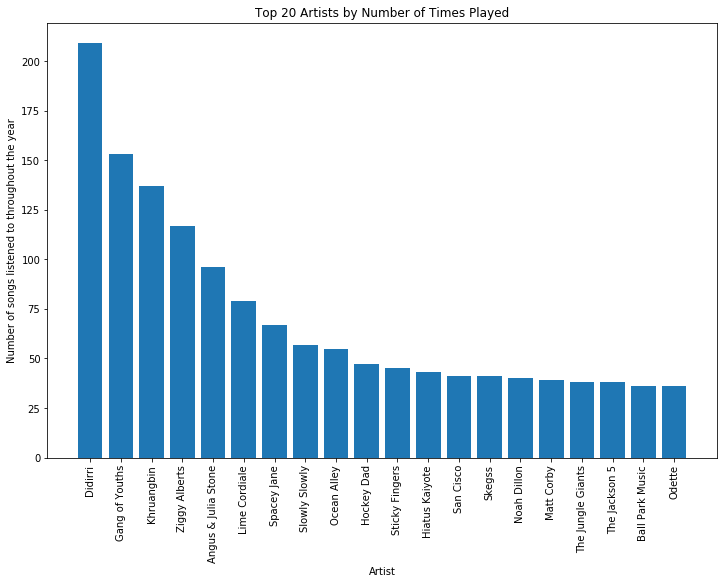

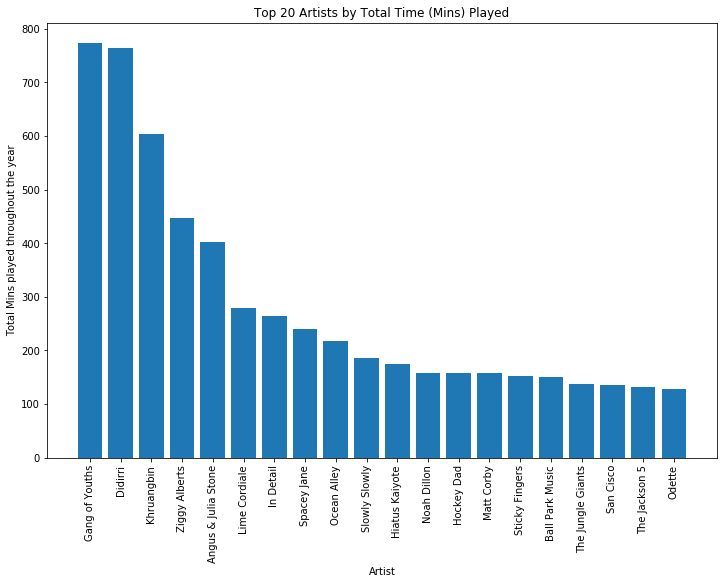

In [48]:
top20(df)

### Month by Month Artist Analysis

Here are your top artists, with how many times you listened to them, month by month! How did your listening experience change over the year?

Jan: Slowly Slowly, 46 times
Feb: Robbie Miller, 15 times
Mar: Noah Dillon, 26 times
Apr: Lukas Graham, 12 times
May: Cousin Tony's Brand New Firebird, 7 times
Jun: Sticky Fingers, 6 times
Jul: Sam Fender, 32 times
Aug: Khruangbin, 63 times
Sep: Ziggy Alberts, 53 times
Oct: Didirri, 111 times
Nov: Gang of Youths, 48 times
Dec: The Kooks, 26 times

Now, for your top 5 overall artists for the year, how did your listening vary over the year?


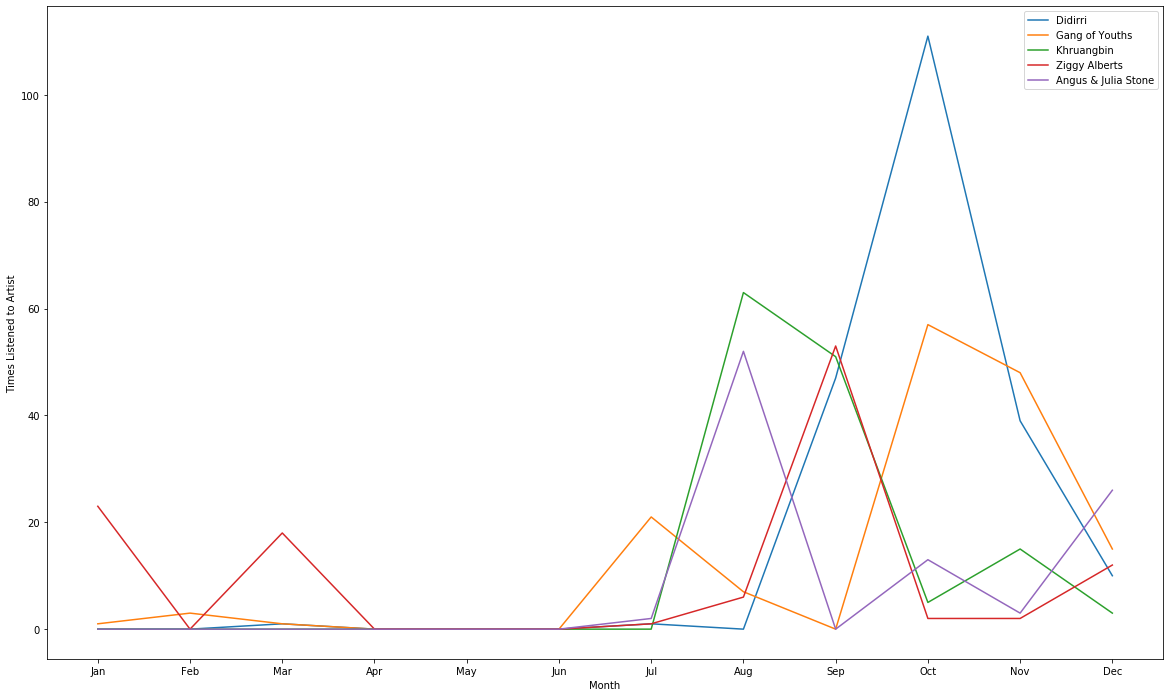


What month did you really like Spotify? What month did you need some peace and quiet? Here's your month by month total hour listening breakdown.


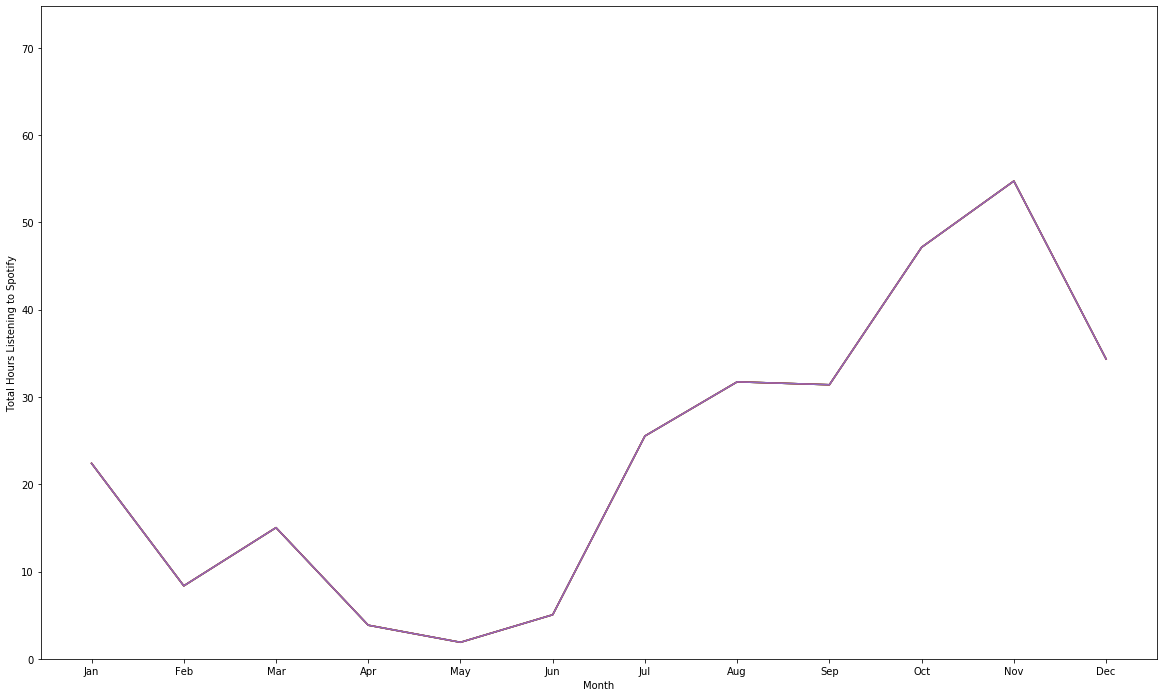

In [49]:
top_artist_per_month(df)

## Top 100 Songs

Here are your top 100 songs! Was it what you expected? If there are more than 100 songs, this is because you listened to those songs the same amount of time as your 100th song!

Rank                                                    Song                              Artist      Times
   1                                                    Jude                             Didirri         40
   2                                           Temper Temper                       Lime Cordiale         23
   3                                               Strangers                        Tia Gostelow         23
   4                                                Midnight                          Khruangbin         22
   5                                        Sunbleached Girl                           Shag Rock         19
   6                                            Miracle Love                          Matt Corby         19
   7                                              Act Yr Age      

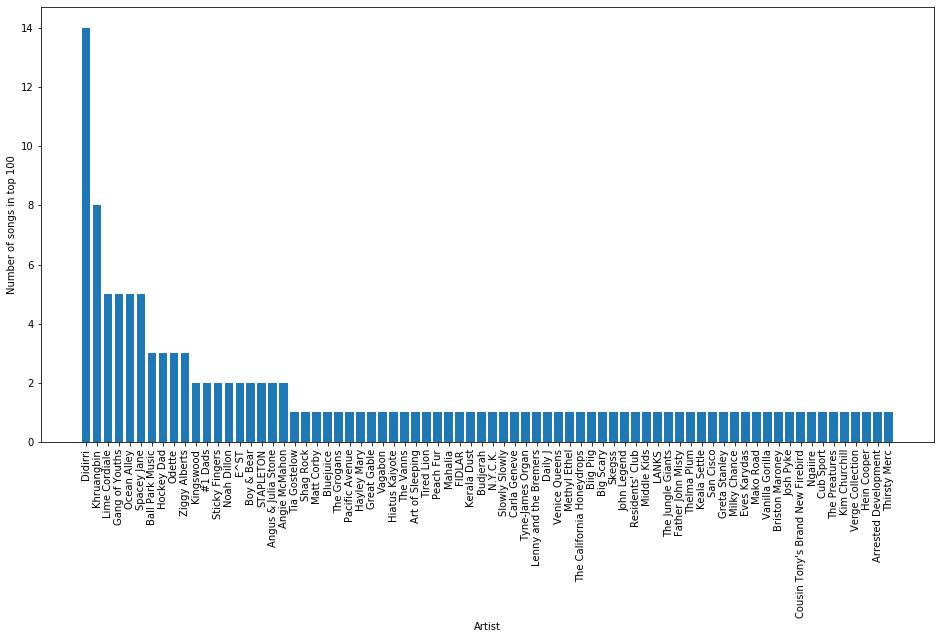

In [50]:
topsong_func(df)

### Most Skipped Songs and Artists

In [51]:
skipped_songs_and_artists(sk)

So which artists did you have too much of that you skipped them the most? These are the number of times you skipped artists (that is, you skipped after listening to less than 30 seconds of the song)

Rank                   Top Artist By Times Skipped           Number of Times
   1                                     San Cisco                        18
   2                                       Didirri                        15
   3                             The Jungle Giants                        15
   4                                    Khruangbin                        12
   5                                  Methyl Ethel                        11
   6                                 Ziggy Alberts                         8
   7                               Ball Park Music                         6
   8                                Gang of Youths                         6
   9                                         Gordi                         5
  10                          

### Daily Breakdown

Which artist did you wake up to most? Which did you fall asleep to? Here is the breakdown of what artist you listened to most, by time of the day.

12am-6am Didirri 24
6am-11am Ziggy Alberts 68
11am-3pm Didirri 37
3pm-7pm Didirri 63
7pm-12am Gang of Youths 75

And here is an hour by hour breakdown! This tells you which artist you listened to most at a particular hour across the whole year!
00 Hiatus Kaiyote 16
01 Didirri 8
02 The California Honeydrops 3
03 The Rubens 2
04 Angus & Julia Stone 3
05 Hiatus Kaiyote 1
06 Ziggy Alberts 11
07 Ziggy Alberts 17
08 Ziggy Alberts 20
09 The Jackson 5 18
10 Angus & Julia Stone 13
11 Didirri 12
12 The Kooks 14
13 Khruangbin 13
14 The Jungle Giants 15
15 Khruangbin 18
16 Khruangbin 22
17 Didirri 23
18 Gang of Youths 27
19 Gang of Youths 19
20 Gang of Youths 19
21 Khruangbin 31
22 Angus & Julia Stone 15
23 Didirri 17

At what time did you listen to spotify most? What were your quiet periods? Here is an hour by hour breakdown of how many songs you play

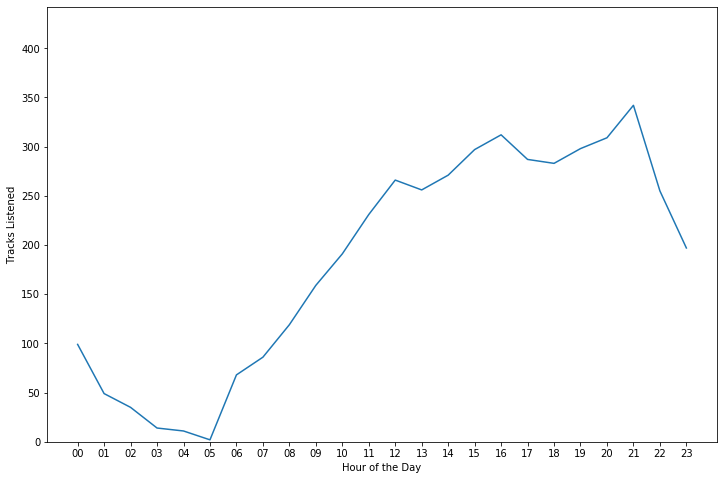

In [52]:
daybreakdown(df)

Hope that all made sense! Let me know if you have any questions :)

Much love,

Yuval.